In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('../data/raw/clinvar_conflicting.csv',
                 dtype={'CHROM': str})

/var/folders/tl/5pdn6vld70l0ndj9lvltyvxw0000gn/T/ipykernel_29598/4074411788.py:7: DtypeWarning: Columns (38,40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/raw/clinvar_conflicting.csv',


In [ ]:
# =========================
# 2) Overview / schema
# =========================
print("\n--- SHAPE ---")
print(df.shape)

print("\n--- INFO ---")
df.info()

print("\n--- TARGET CHECK ---")
assert "CLASS" in df.columns, "No existeix la columna 'CLASS'!"
print(df["CLASS"].value_counts(dropna=False))
print(df["CLASS"].value_counts(normalize=True, dropna=False).round(4))


--- SHAPE ---
(65188, 46)

--- INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  object 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC          

La variable objectiu CLASS existeix i no té valors nuls. La distribució és:
CLASS=0 (consistent): 48.754 casos (~74.8%)
CLASS=1 (conflicting): 16.434 casos (~25.2%)
Això indica un desbalanceig moderat. No és extrem, però és rellevant.

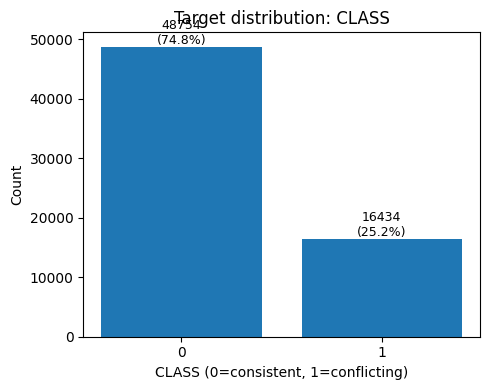

In [ ]:

# =========================
# 3) Target distribution plot
# =========================
counts = df["CLASS"].value_counts().sort_index()
pct = df["CLASS"].value_counts(normalize=True).sort_index() * 100

plt.figure(figsize=(5, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Target distribution: CLASS")
plt.xlabel("CLASS (0=consistent, 1=conflicting)")
plt.ylabel("Count")
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v}\n({pct.iloc[i]:.1f}%)", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.show()


L’anàlisi de valors nuls mostra que hi ha columnes amb missing molt elevat. En concret, hi ha 9 columnes amb >95% missing:

MOTIF_SCORE_CHANGE, HIGH_INF_POS, MOTIF_POS, MOTIF_NAME, DISTANCE, SSR, CLNSIGINCL, CLNDISDBINCL, CLNDNINCL.

Aquest patró suggereix que aquestes variables són molt poc informatives a nivell global (quasi sempre absents) i que, en una fase posterior de preprocessing, podrien ser candidates a eliminar o a tractar-se de forma específica. En canvi, altres camps com INTRON (~86% missing) o SIFT/PolyPhen/BLOSUM62 (~60% missing) tenen missing alt però no extrem; aquests casos poden ser interessants perquè el “fet de tenir o no anotació” pot contenir informació (a verificar amb missingness per classe).

In [10]:
# =========================
# 4) Missing values (global)
# =========================
missing_tbl = (
    df.isna()
      .mean()
      .mul(100)
      .sort_values(ascending=False)
      .to_frame("missing_%")
)
missing_tbl["dtype"] = df.dtypes.astype(str)
missing_tbl["nunique"] = df.nunique(dropna=True)
missing_tbl["n_missing"] = df.isna().sum()

display(missing_tbl.head(30))

# Recomanació simple de drop per molt missing
DROP_MISSING_THRESHOLD = 95.0
cols_drop_missing = missing_tbl.index[missing_tbl["missing_%"] > DROP_MISSING_THRESHOLD].tolist()
print(f"\nColumns with >{DROP_MISSING_THRESHOLD}% missing: {len(cols_drop_missing)}")
print(cols_drop_missing[:30])

,missing_%,dtype,nunique,n_missing
MOTIF_SCORE_CHANGE,99.996932,float64,2,65186
HIGH_INF_POS,99.996932,object,1,65186
MOTIF_POS,99.996932,float64,1,65186
MOTIF_NAME,99.996932,object,2,65186
DISTANCE,99.834325,float64,96,65080
SSR,99.800577,float64,2,65058
CLNSIGINCL,99.743818,object,137,65021
CLNDISDBINCL,99.743818,object,93,65021
CLNDNINCL,99.743818,object,101,65021
INTRON,86.495981,object,1929,56385



Columns with >95.0% missing: 9
['MOTIF_SCORE_CHANGE', 'HIGH_INF_POS', 'MOTIF_POS', 'MOTIF_NAME', 'DISTANCE', 'SSR', 'CLNSIGINCL', 'CLNDISDBINCL', 'CLNDNINCL']


Missing values per classe (taula mbc)

Quan compares el percentatge de missing entre CLASS=0 i CLASS=1, destaca especialment:
CLNVI: missing molt diferent entre classes (≈61.6% en 0 vs ≈45.7% en 1; diferència ~15.8 punts).
Això és important perquè indica que la presència/absència de dades a CLNVI pot estar associada al target (no vol dir causalitat, però sí potencial valor predictiu). També hi ha diferències petites però consistents en SIFT, PolyPhen i BLOSUM62 (~2 punts), i en camps de posició (CDS_position, Protein_position, etc.) (~1.9 punts). Aquest resultat és especialment útil per documentar que la missingness no és completament aleatòria i, més endavant, pot requerir decisions acurades d’imputació o features indicadors de missing.

In [11]:
# =========================
# 5) Missing values per CLASS (CRÍTIC)
# =========================
def missing_by_class(data: pd.DataFrame, target="CLASS") -> pd.DataFrame:
    out = []
    for c in data.columns:
        if c == target:
            continue
        # % missing per cada valor de classe
        grp = data.groupby(target)[c].apply(lambda s: s.isna().mean() * 100)
        row = {"col": c}
        for k, v in grp.items():
            row[f"missing_%_class_{k}"] = v
        row["missing_diff_abs"] = abs(row.get("missing_%_class_0", np.nan) - row.get("missing_%_class_1", np.nan))
        out.append(row)
    res = pd.DataFrame(out).sort_values("missing_diff_abs", ascending=False)
    return res

mbc = missing_by_class(df, "CLASS")
display(mbc.head(30))

,col,missing_%_class_0,missing_%_class_1,missing_diff_abs
14,CLNVI,61.555975,45.746623,15.809352
44,BLOSUM62,61.332403,58.981380,2.351023
35,SIFT,62.466669,60.222709,2.243960
36,PolyPhen,62.497436,60.374833,2.122603
28,CDS_position,14.784428,16.715346,1.930918
29,Protein_position,14.784428,16.715346,1.930918
31,Codons,14.864421,16.776196,1.911774
30,Amino_acids,14.864421,16.776196,1.911774
43,CADD_RAW,1.973171,0.791043,1.182128
42,CADD_PHRED,1.973171,0.791043,1.182128


CHROM (distribució de cromosomes)

La variable CHROM (cromosoma) conté 24 categories (1–22, X i MT), cosa coherent amb l’anotació genòmica humana. La distribució no és uniforme: els cromosomes 2, 17, 11 i 1 acumulen més variants dins el dataset, mentre que MT (mitocondrial) apareix molt poc (només 16 registres). Aquest desequilibri pot reflectir tant diferències de mida/contingut genètic dels cromosomes com el biaix dels variants reportats a ClinVar.


Proporció de conflicte per cromosoma (chrom_conflict_rate)

La taxa de CLASS=1 varia entre cromosomes, però la majoria es mou aproximadament al voltant del 0.18–0.29. Destaca MT amb una proporció molt alta (~0.69), però aquest resultat s’ha d’interpretar amb molta cautela perquè el nombre de variants a MT és molt petit (n=16), i per tant la proporció és inestable. En la resta de cromosomes, les diferències són moderades: per exemple, cromosomes com 15/20/14/13 tenen una proporció una mica superior, mentre que el 22 i el 5 són dels més baixos. Aquest patró suggereix que CHROM pot aportar informació, però probablement no serà un predictor fort per si sol.


POS (resum estadístic + histograma)

La variable POS representa la posició genòmica (GRCh37) dins del cromosoma. El rang és molt ampli (min ~961, max ~2.476×10^8), amb una distribució heterogènia. L’histograma mostra diversos “pics” i zones amb més densitat, cosa esperable perquè POS no és comparable directament entre cromosomes (cada cromosoma té una escala pròpia) i perquè el dataset conté variants concentrats en regions d’interès clínic. Aquest resultat justifica tractar POS amb cura en models: pot requerir normalització per cromosoma o altres estratègies, però en aquesta fase simplement es documenta el comportament.


REF i ALT (distribució d’al·lels)

Les variables REF i ALT mostren que la major part de variants són SNVs (canvis d’un sol nucleòtid) amb valors majoritaris A/C/G/T. Tot i això, també apareixen al·lels multi-caràcter (p. ex. CT, GC, CAG…), que corresponen a indels o substitucions més complexes. La presència d’aquestes categories menys freqüents és rellevant perquè implica que REF/ALT no són estrictament “base nucleotídica” sempre, i pot ser necessari agrupar o codificar de manera adequada en etapes posteriors.


--- CHROM distribution (top) ---


CHROM
2     8645
17    5394
11    4846
1     4454
16    3927
19    3911
5     3643
7     2867
12    2750
9     2744
13    2646
3     2529
10    2341
6     2159
14    1974
X     1926
8     1852
15    1725
4     1206
22    1135
18     896
21     843
20     759
MT      16
Name: count, dtype: int64

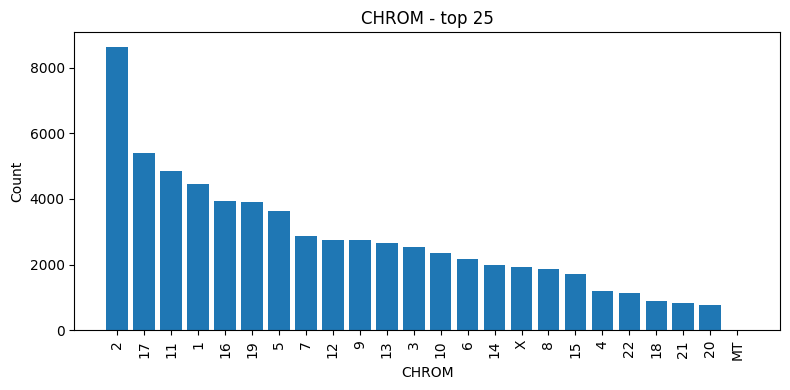

CHROM
MT    0.687500
15    0.291594
20    0.291173
14    0.290274
13    0.288360
21    0.288256
7     0.278340
1     0.273238
6     0.270032
X     0.269990
10    0.269970
9     0.266764
18    0.266741
4     0.264511
2     0.263852
3     0.261368
8     0.244600
19    0.238814
12    0.238182
17    0.231368
16    0.229437
11    0.209038
5     0.198737
22    0.185022
Name: CLASS, dtype: float64


--- POS describe ---


count    6.518800e+04
mean     7.757594e+07
std      5.974051e+07
min      9.610000e+02
25%      3.254179e+07
50%      5.797021e+07
75%      1.127454e+08
max      2.476080e+08
Name: POS, dtype: float64

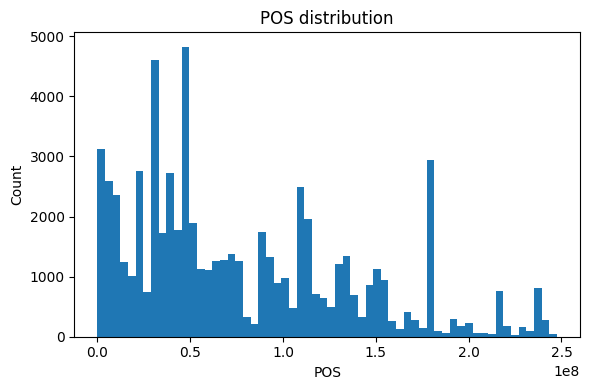


--- REF distribution ---


REF
C      21798
G      21361
A       9845
T       9421
CT       126
GC       113
TG       105
AG       104
AC       103
GA        91
CA        89
TC        81
TA        80
AT        75
CG        58
CAG       51
GT        48
ACT       33
CAT       33
CTT       30
Name: count, dtype: int64


--- ALT distribution ---


ALT
T       20409
A       20205
G       11782
C       11429
TA        118
CT         93
CA         77
AT         75
GA         67
GT         64
TG         51
GC         42
AG         40
AC         37
TC         33
AA         30
CG         30
TT         27
GAA         8
TGCC        8
Name: count, dtype: int64

In [12]:
# =========================
# 6) Genomic basic columns: CHROM, POS, REF, ALT
# =========================
basic_cols = ["CHROM", "POS", "REF", "ALT"]
for c in basic_cols:
    assert c in df.columns, f"Falta columna: {c}"

print("\n--- CHROM distribution (top) ---")
display(df["CHROM"].value_counts().head(30))

plt.figure(figsize=(8, 4))
chrom_counts = df["CHROM"].value_counts().head(25)
plt.bar(chrom_counts.index.astype(str), chrom_counts.values)
plt.title("CHROM - top 25")
plt.xlabel("CHROM")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Conflicte per cromosoma (proporció de CLASS=1)
chrom_conflict_rate = df.groupby("CHROM")["CLASS"].mean().sort_values(ascending=False)
display(chrom_conflict_rate.head(30))

# POS numeric summary (vigila si hi ha coses rares)
print("\n--- POS describe ---")
display(df["POS"].describe())

plt.figure(figsize=(6, 4))
plt.hist(df["POS"].dropna(), bins=60)
plt.title("POS distribution")
plt.xlabel("POS")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# REF / ALT distributions
print("\n--- REF distribution ---")
display(df["REF"].value_counts().head(20))

print("\n--- ALT distribution ---")
display(df["ALT"].value_counts().head(20))

Freqüències al·lèliques (AF_ESP, AF_EXAC, AF_TGP)

Distribucions (histogrames)
Les tres variables de freqüència al·lèlica (AF_ESP, AF_EXAC, AF_TGP) presenten una distribució fortament asimètrica cap a 0: la gran majoria de variants tenen freqüències molt baixes o zero, i existeix una cua dreta llarga fins a valors propers a 0.5. Això és coherent amb un escenari genòmic on moltes variants clíniques són rares en poblacions de referència. Aquesta asimetria indica que aquestes variables poden necessitar transformacions o tractaments especials (p. ex. log o binarització), però això es decidirà en preprocessing.


Boxplots per classe (AF_* by CLASS)

Els boxplots mostren que, en general, les freqüències al·lèliques són molt baixes per ambdues classes, amb mediana pròxima a 0. Tot i així, s’observa una diferència subtil: la classe 0 (consistent) tendeix a tenir una dispersió una mica més gran i valors més elevats en el rang superior, mentre que la classe 1 (conflicting) es concentra lleugerament més a valors baixos. Això podria suggerir (amb cautela) que variants més comunes tenen interpretacions més establertes i, per tant, menys conflicte, però caldrà validar-ho amb models i mètriques posteriorment.

Cardinalitat (nunique / unique_%)

La taula de cardinalitat mostra que hi ha diverses columnes amb cardinalitat molt alta, com CLNHGVS (100% únic), POS (~96.8% únic) i CADD_RAW (~97.9% únic). Aquest tipus de variables poden actuar gairebé com identificadors i poden ser difícils d’aprofitar amb codificacions simples. També hi ha camps d’anotació com CLNDN, CLNDISDB, CLNVI, i variables de posició/proteïna (cDNA_position, CDS_position, Protein_position) amb molts valors diferents, indicant que el dataset conté informació textual/estructurada amb alta complexitat. En etapes futures caldrà decidir quines variables s’utilitzen i amb quin tipus d’encoding/feature engineering.
High-cardinality object columns

S’identifiquen 16 columnes categòriques/textuals amb >200 valors únics, com CLNHGVS, CLNVI, CLNDN, CLNDISDB, SYMBOL, Feature, i altres relacionades amb posicions o codons. Aquest resultat és important perquè anticipa que one-hot encoding directe podria explotar dimensionalitat o generar models molt grans, i que pot ser més adequat aplicar estratègies com agrupacions, encoding target, hashing o selecció de categories més freqüents (a decidir més endavant).


AF cols: ['AF_ESP', 'AF_EXAC', 'AF_TGP']


,AF_ESP,AF_EXAC,AF_TGP
count,65188.000000,65188.000000,65188.000000
mean,0.014511,0.014492,0.015263
std,0.057795,0.059542,0.059527
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000040,0.000000
75%,0.001200,0.001230,0.001600
max,0.499000,0.499890,0.499800


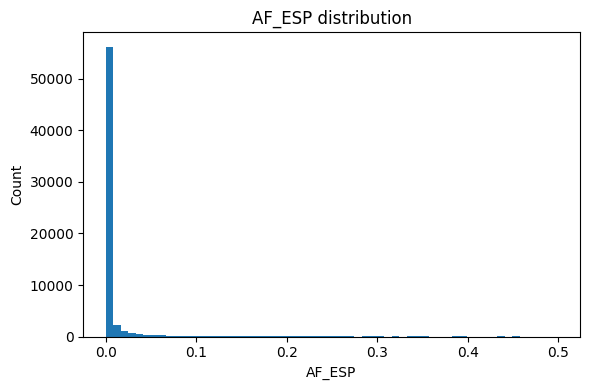

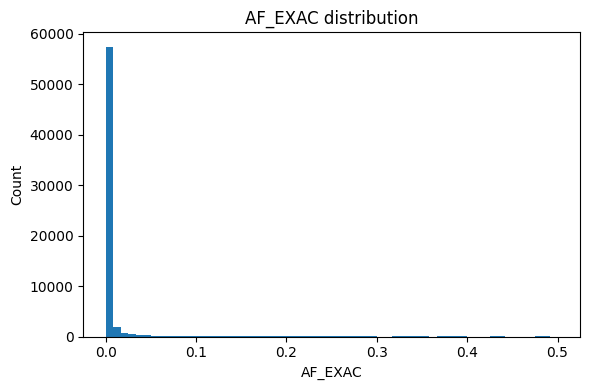

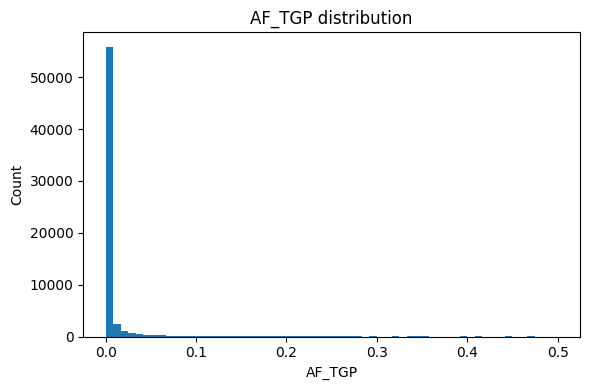

/var/folders/tl/5pdn6vld70l0ndj9lvltyvxw0000gn/T/ipykernel_29598/3873489356.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["CLASS=0", "CLASS=1"], showfliers=False)


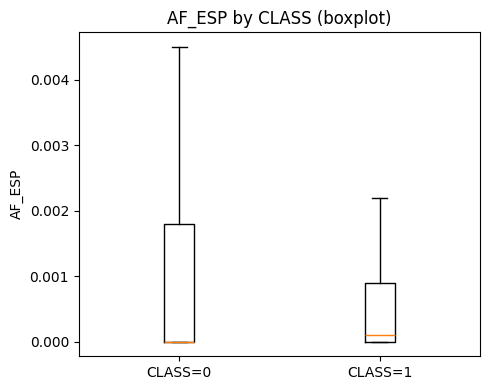

/var/folders/tl/5pdn6vld70l0ndj9lvltyvxw0000gn/T/ipykernel_29598/3873489356.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["CLASS=0", "CLASS=1"], showfliers=False)


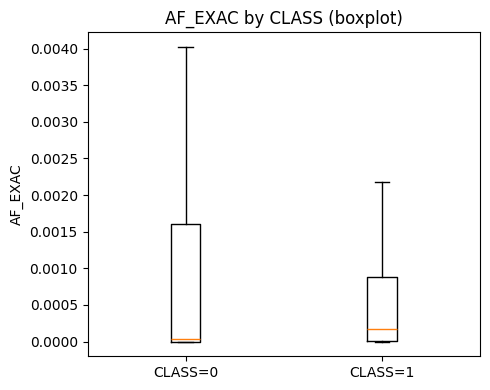

/var/folders/tl/5pdn6vld70l0ndj9lvltyvxw0000gn/T/ipykernel_29598/3873489356.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["CLASS=0", "CLASS=1"], showfliers=False)


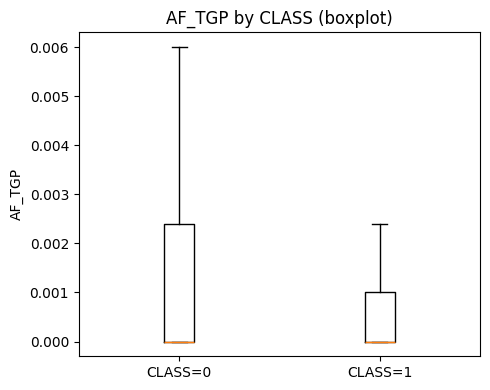

,dtype,nunique,unique_%,missing_%
CLNHGVS,object,65188,100.000,0.000
CADD_RAW,float64,63803,97.875,1.675
POS,int64,63115,96.820,0.000
CLNVI,object,27654,42.422,57.570
cDNA_position,object,13970,21.430,13.628
CDS_position,object,13663,20.959,15.271
CADD_PHRED,float64,9324,14.303,1.675
CLNDN,object,9260,14.205,0.000
CLNDISDB,object,9234,14.165,0.000
Protein_position,object,7339,11.258,15.271



High-cardinality object columns (nunique > 200): 16
['CLNHGVS', 'CLNVI', 'cDNA_position', 'CDS_position', 'CLNDN', 'CLNDISDB', 'Protein_position', 'EXON', 'Feature', 'SYMBOL', 'Codons', 'INTRON', 'Amino_acids', 'REF', 'ALT', 'Allele']


In [13]:
# =========================
# 7) Allele frequencies: AF_ESP, AF_EXAC, AF_TGP
# =========================
af_cols = [c for c in ["AF_ESP", "AF_EXAC", "AF_TGP"] if c in df.columns]
print("\nAF cols:", af_cols)

# Convert to numeric (algunes poden venir com string)
for c in af_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

display(df[af_cols].describe())

# Distributions (skewed cap a 0)
for c in af_cols:
    plt.figure(figsize=(6, 4))
    x = df[c].dropna()
    plt.hist(x, bins=60)
    plt.title(f"{c} distribution")
    plt.xlabel(c)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# Boxplot per classe (simple, sense seaborn)
for c in af_cols:
    plt.figure(figsize=(5, 4))
    data0 = df.loc[df["CLASS"] == 0, c].dropna()
    data1 = df.loc[df["CLASS"] == 1, c].dropna()
    plt.boxplot([data0, data1], labels=["CLASS=0", "CLASS=1"], showfliers=False)
    plt.title(f"{c} by CLASS (boxplot)")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()


# =========================
# 8) Cardinality (high vs low) + suggested handling
# =========================
card_tbl = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "nunique": df.nunique(dropna=True),
    "unique_%": (df.nunique(dropna=True) / len(df) * 100).round(3),
    "missing_%": (df.isna().mean() * 100).round(3)
}).sort_values(["unique_%", "nunique"], ascending=False)

display(card_tbl.head(40))

# Heurística: high-cardinality categòriques
high_card = card_tbl[(card_tbl["dtype"] == "object") & (card_tbl["nunique"] > 200)].index.tolist()
print("\nHigh-cardinality object columns (nunique > 200):", len(high_card))
print(high_card[:30])

Correlació de variables numèriques amb la variable objectiu

L’anàlisi de correlació lineal (coeficient de Pearson) entre les variables numèriques i CLASS mostra que cap variable presenta una correlació forta amb la classe. Les correlacions positives més elevades (SSR, DISTANCE) són molt baixes (≈0.04), mentre que la majoria de variables tenen correlacions pròximes a zero.
En canvi, s’observa una correlació negativa moderada però encara feble entre CLASS i les freqüències al·lèliques (AF_TGP ≈ -0.13, AF_ESP ≈ -0.13, AF_EXAC ≈ -0.12). Aquest resultat suggereix que variants amb major freqüència en poblacions de referència tendeixen a tenir menys probabilitat de classificació conflictiva, la qual cosa és coherent amb el fet que variants comunes solen estar millor caracteritzades clínicament.
Les puntuacions de deleteriousness (CADD_RAW, CADD_PHRED, LoFtool, BLOSUM62) mostren correlacions molt baixes (properes a zero), indicant que, almenys de manera lineal i individual, no tenen una relació forta amb la presència de conflicte en la classificació.
En conjunt, aquests resultats indiquen que no existeix cap predictor numèric dominant de manera individual, i que el problema probablement requereix la combinació de múltiples variables i/o relacions no lineals per capturar patrons rellevants.

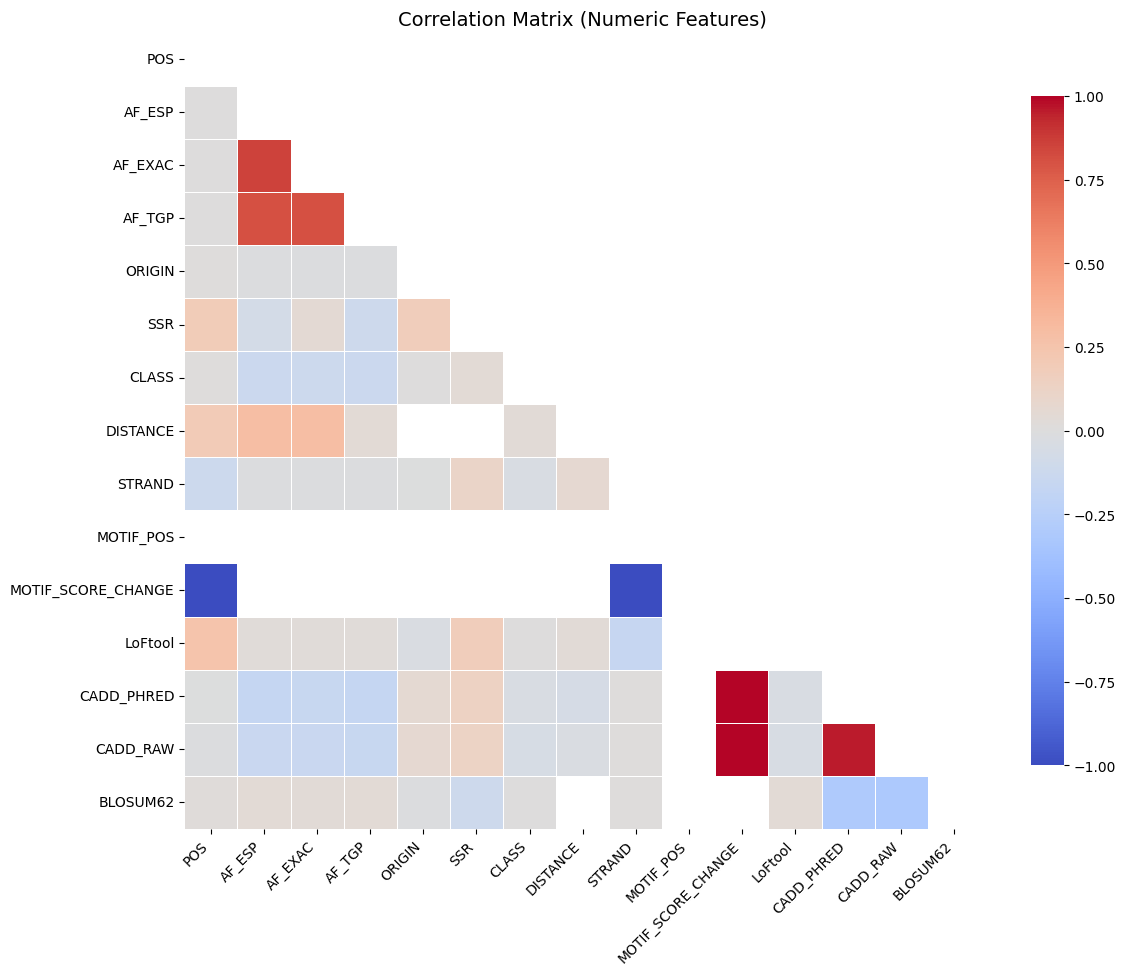

In [18]:
# =========================
# 11) Correlation (numeric only) - improved visualization
# =========================
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Només variables numèriques
num_df = df.select_dtypes(include=[np.number]).copy()

corr = num_df.corr()

# Mask per ocultar la meitat superior (matriu simètrica)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))

sns.heatmap(
    corr,
    mask=mask,
    cmap="coolwarm",      # colormap diverging clar
    center=0,             # centre en 0 (molt important!)
    vmin=-1, vmax=1,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Matrix (Numeric Features)", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [17]:
class_corr.head(15)

CLASS                 1.000000
SSR                   0.042410
DISTANCE              0.036865
POS                   0.012061
ORIGIN                0.004357
BLOSUM62              0.001593
LoFtool               0.000045
STRAND               -0.031369
CADD_PHRED           -0.037713
CADD_RAW             -0.053485
AF_EXAC              -0.121213
AF_ESP               -0.126538
AF_TGP               -0.130077
MOTIF_POS                  NaN
MOTIF_SCORE_CHANGE         NaN
Name: CLASS, dtype: float64